In [1]:
# from ChatGPT-4
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, GPT2Model
import torch

class EarlyExitingGPT2Model(GPT2Model):
    def __init__(self, config, exit_layer):
        super().__init__(config)
        self.exit_layer = exit_layer

    def forward(self, input_ids, attention_mask=None):
        hidden_states = self.wte(input_ids)  # Word token embeddings
        for i, block in enumerate(self.h):
            hidden_states = block(hidden_states)[0]
            if i == self.exit_layer - 1:
                break
        return hidden_states

In [2]:
def get_hiddenstates_attn(text, model, tokenizer):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    print("Nr. of input tokens: ", len(input_ids))
    with torch.no_grad():
        output = model(input_ids=input_ids)

    hidden_states = output.hidden_states
    attentions = output.attentions
    return hidden_states, attentions

In [3]:
# Load the configuration and create a new model instance
config = GPT2Config.from_pretrained('gpt2-medium')
# early_exiting_model = EarlyExitingGPT2Model(config, exit_layer=12)
gpt2_medium_model = GPT2Model.from_pretrained('gpt2-medium', output_attentions=True, output_hidden_states=True)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")

text = "Hello, my dog is cute"

In [4]:
config

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1024,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 1024,
  "n_special": 0,
  "predict_special_tokens": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.40.0",
  "use_cache": true,
  "vocab_size": 50257
}

In [5]:
from torchinfo import summary as ti_summary

ti_summary(gpt2_medium_model, depth=3)

Layer (type:depth-idx)                        Param #
GPT2Model                                     --
├─Embedding: 1-1                              51,463,168
├─Embedding: 1-2                              1,048,576
├─Dropout: 1-3                                --
├─ModuleList: 1-4                             --
│    └─GPT2Block: 2-1                         --
│    │    └─LayerNorm: 3-1                    2,048
│    │    └─GPT2Attention: 3-2                4,198,400
│    │    └─LayerNorm: 3-3                    2,048
│    │    └─GPT2MLP: 3-4                      8,393,728
│    └─GPT2Block: 2-2                         --
│    │    └─LayerNorm: 3-5                    2,048
│    │    └─GPT2Attention: 3-6                4,198,400
│    │    └─LayerNorm: 3-7                    2,048
│    │    └─GPT2MLP: 3-8                      8,393,728
│    └─GPT2Block: 2-3                         --
│    │    └─LayerNorm: 3-9                    2,048
│    │    └─GPT2Attention: 3-10               4,198,400

In [6]:
# Attn is the score just before the *V
hidden_states, attn = get_hiddenstates_attn(text, gpt2_medium_model, tokenizer)

Nr. of input tokens:  1


In [7]:
type(hidden_states)

tuple

In [8]:
hidden_states[0].shape

torch.Size([1, 6, 1024])

#### Attention is $n\times n$ since it's a pairwise importance measure

In [9]:
attn[2].shape

torch.Size([1, 16, 6, 6])

### Manual implementation of `fwd()` to extract LayerNorm inputs & outputs

In [10]:
# Don't need this. Use modeling_gpt2.py:GPT2Block, debug before/after LayerNorm
# TODO edit this to perform Top-K LayerNorm
# From GPT-4: https://chat.openai.com/share/a99ee779-f8c8-4bad-9511-483606ba0cca
from transformers.models.gpt2.modeling_gpt2 import GPT2Block
from transformers import GPT2Tokenizer
from typing import Optional, Tuple, Union

class TopKLayerNormGPT2Block(GPT2Block):
    def __init__(self, config):
        super().__init__(config)
        
    def forward(
        self,
        hidden_states: Optional[Tuple[torch.FloatTensor]],
        layer_past: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        use_cache: Optional[bool] = False,
        output_attentions: Optional[bool] = False,
    ) -> Union[Tuple[torch.Tensor], Optional[Tuple[torch.Tensor, Tuple[torch.FloatTensor, ...]]]]:
        residual = hidden_states
        hidden_states = self.ln_1(hidden_states)
        attn_outputs = self.attn(
            hidden_states,
            layer_past=layer_past,
            attention_mask=attention_mask,
            head_mask=head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
        )
        attn_output = attn_outputs[0]  # output_attn: a, present, (attentions)
        outputs = attn_outputs[1:]
        # residual connection
        hidden_states = attn_output + residual

        if encoder_hidden_states is not None:
            # add one self-attention block for cross-attention
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with "
                    "cross-attention layers by setting `config.add_cross_attention=True`"
                )
            residual = hidden_states
            hidden_states = self.ln_cross_attn(hidden_states)
            cross_attn_outputs = self.crossattention(
                hidden_states,
                attention_mask=attention_mask,
                head_mask=head_mask,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                output_attentions=output_attentions,
            )
            attn_output = cross_attn_outputs[0]
            # residual connection
            hidden_states = residual + attn_output
            outputs = outputs + cross_attn_outputs[2:]  # add cross attentions if we output attention weights

        residual = hidden_states
        hidden_states = self.ln_2(hidden_states)
        feed_forward_hidden_states = self.mlp(hidden_states)
        # residual connection
        hidden_states = residual + feed_forward_hidden_states

        if use_cache:
            outputs = (hidden_states,) + outputs
        else:
            outputs = (hidden_states,) + outputs[1:]

        return outputs  # hidden_states, present, (attentions, cross_attentions)

In [11]:
# # Example model loading and modification
# from transformers import GPT2Config, GPT2Model

# tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")

# config = GPT2Config()
# model = GPT2Model(config)
# model.h[0] = TopKLayerNormGPT2Block(config)  # Replace the first block for demonstration

# # Example forward pass
# input_ids = tokenizer.encode("ariel is a cs phd student", return_tensors="pt")
# outputs = model(input_ids)

# # Extract LayerNorm inputs
# ln_inputs = outputs[-1][-1]  # Assuming only the first block was replaced

#### Verify Correctness against stock GPT-2 at same layer

In [22]:
import torch
from transformers import GPT2Model, GPT2Config

# Custom block class definition here (as previously defined)
# from your_custom_module import CustomGPT2Block

def compare_models():
    torch.manual_seed(43)

    config = GPT2Config()
    original_model = GPT2Model(config).eval()
    modified_model = GPT2Model(config).eval()

    # new_h0 = TopKLayerNormGPT2Block(config)
    # # Replace the first block of the modified model with the custom block
    # modified_model.h[0] = new_h0
    modified_model.h[0] = TopKLayerNormGPT2Block(config)

    # Ensure both models start with the same weights
    modified_model.load_state_dict(original_model.state_dict())
    modified_model.h[0].load_state_dict(original_model.h[0].state_dict())

    def compare_state_dicts(dict1, dict2):
        # Check if both dictionaries have the same set of keys (parameter names)
        assert dict1.keys() == dict2.keys(), "State dicts have different sets of parameters."
        
        # Check if all tensors in both dictionaries are close
        for key in dict1:
            assert torch.allclose(dict1[key], dict2[key], atol=1e-6), f"Mismatch found in parameter: {key}"

    # assert torch.allclose(original_model.state_dict(), hidden_states_modified, atol=1e-6), "Embedding output mismatch"

    # Prepare input
    input_ids = torch.tensor([[12100, 242, 508, 318, 13, 198]])

    hidden_states_original = original_model.wte(input_ids)
    hidden_states_modified = modified_model.wte(input_ids)
    assert torch.allclose(hidden_states_original, hidden_states_modified, atol=1e-6), "Embedding output mismatch"
    print("Word Token Embeddings output match")

    modified_model.load_state_dict(original_model.state_dict())
    modified_model.h[0].load_state_dict(original_model.h[0].state_dict())

    # Compare state dicts
    state_dict1 = original_model.state_dict()
    state_dict2 = modified_model.state_dict()

    compare_state_dicts(state_dict1, state_dict2)
    print("State Dicts match")

    original_h0 = original_model.h[0](hidden_states_original)[0]
    modified_h0 = modified_model.h[0](hidden_states_modified)[0]
    assert torch.allclose(original_h0, modified_h0, atol=1e-6), "First Hidden State output mismatch"
    print("First Hidden State output match")


    # Get outputs from both models
    with torch.no_grad():
        original_output = original_model(input_ids)[0]
        modified_output = modified_model(input_ids)[0]

    # Compare outputs
    # print("Difference between original and modified model outputs:", torch.sum((original_output - modified_output) ** 2))
    print("original_output: ", original_output)
    print("modified_output: ", modified_output)

compare_models()


Word Token Embeddings output match
State Dicts match


##### <font color='red'>Fails</font>

In [ ]:
outputs

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[ 0.2464,  1.4542,  0.2508,  ...,  0.7829, -0.3028,  1.5124],
         [ 1.4531,  0.1231,  0.5521,  ..., -0.6331,  0.9294,  0.8452],
         [ 1.3695, -1.6607,  0.5966,  ...,  0.2552,  0.5448, -0.1715],
         ...,
         [ 1.7666, -2.1220, -0.8764,  ...,  0.4726,  1.6389, -0.1402],
         [ 1.1706, -0.9836,  0.4577,  ...,  0.3069,  0.3220, -0.8828],
         [ 0.0530, -1.2568,  0.0125,  ...,  0.6572,  1.3371, -0.9808]]],
       grad_fn=<ViewBackward0>), past_key_values=((tensor([[[[-0.0194, -0.2735, -0.4559,  ...,  0.0875, -0.6530,  0.6981],
          [-0.3479,  0.2874, -0.0608,  ..., -0.3080,  0.5808, -0.8519],
          [-0.2116, -0.6707, -0.0784,  ..., -0.0107,  0.4759, -0.0268],
          ...,
          [ 0.5499, -0.9602, -0.0313,  ..., -0.0875,  0.0368,  0.6028],
          [ 0.0415, -0.1072,  0.4097,  ...,  0.5615, -0.6842,  0.8332],
          [-0.3610,  0.0154,  0.2739,  ..., -0.2877, -0.4979, -0.4553]],

In [ ]:
len(ln_inputs)

2

In [ ]:
ln_inputs[0].shape

torch.Size([1, 12, 8, 64])

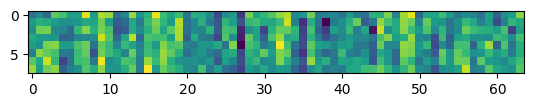

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(ln_inputs[0][0][0].detach().numpy())

In [ ]:
from utils.datasets import get_top_n_tiny_shakespeare

longest_shakespeare = get_top_n_tiny_shakespeare(1, mode="longest")[0]['Text']
longest_shakespeare

"Our king, being ready to leap out of\nhimself for joy of his found daughter, as if that\nOur king, being ready to leap out of\njoy were now become a loss, cries 'O, thy mother,\nthy mother!' then asks Bohemia forgiveness; then\nembraces his son-in-law; then again worries he his\ndaughter with clipping her; now he thanks the old\nshepherd, which stands by like a weather-bitten\nconduit of many kings' reigns. I never heard of such\nanother encounter, which lames report to follow it\nand undoes description to do it.\n\nSecond Gentleman:\nWhat, pray you, became of Antigonus, that carried\nhence the child?\n\nThird Gentleman:\nLike an old tale still, which will have matter to\nrehearse, though credit be asleep and not an ear\nopen. He was torn to pieces with a bear: this\navouches the shepherd's son; who has not only his\ninnocence, which seems much, to justify him, but a\nhandkerchief and rings of his that Paulina knows.\n\nFirst Gentleman:\nWhat became of his bark and his followers?\n\nT

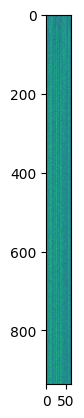

In [ ]:
input_ids = tokenizer.encode(longest_shakespeare, return_tensors="pt")
outputs = model(input_ids)

# Extract LayerNorm inputs
ln_inputs = outputs[-1][-1]

plt.imshow(ln_inputs[0][0][0].detach().numpy())

## Apply Perplexity